## Load libraries

In [1]:
import os
import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import precision_recall_fscore_support

from alphai_watson.performance import GANPerformanceAnalysis
from alphai_watson.transformer import NullTransformer
from alphai_rickandmorty_oracle.datasource.mnist import MNISTDataSource
from alphai_rickandmorty_oracle.detective import RickAndMortyDetective
from alphai_rickandmorty_oracle.model_mnist import RickAndMorty

from matplotlib import pyplot as plt

/opt/anaconda/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/anaconda/envs/ai/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
DEBUG:matplotlib:CACHEDIR=/home/ubuntu/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/ubuntu/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends:backend agg version v2.2


Enabling weight norm
Uppercase local vars:
	BATCH_SIZE: 50
	CRITIC_ITERS: 5
	DEFAULT_FIT_EPOCHS: 1000
	DEFAULT_LEARN_RATE: 0.0001
	DEFAULT_TRAIN_ITERS: 5000
	DEFAULT_Z_DIM: 128
	DIAGNOSIS_LEARN_RATE: 0.01
	DIM: 64
	DISC_FILTER_SIZE: 5
	LAMBDA: 10
	LAMBDA_2: 2.0
	OUTPUT_DIM: 784


## Define MNIST Datasource

In [2]:
file_path = '../../tests/resources'

abnormal_digit = 4

# Train and test data file
train_data_file = os.path.join(file_path, 'mnist_data_train_abnormalclass-{}.hd5'.format(abnormal_digit))
test_data_file = os.path.join(file_path, 'mnist_data_test_abnormalclass-{}.hd5'.format(abnormal_digit))

# Model parameters
n_sensors = 28
n_timesteps = 784 // n_sensors

train_data_source = MNISTDataSource(source_file=train_data_file, 
                                    transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                                number_of_sensors=n_sensors))
test_data_source = MNISTDataSource(source_file=test_data_file,
                                   transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                               number_of_sensors=n_sensors))

train_data = train_data_source.get_train_data('NORMAL')

DEBUG:root:Start file parsing.
DEBUG:root:Processing sample type NORMAL.
DEBUG:root:End file parsing.
DEBUG:root:Start file parsing.
DEBUG:root:Processing sample type ABNORMAL.
DEBUG:root:Processing sample type NORMAL.
DEBUG:root:End file parsing.


### Plot input images to verify correctness

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


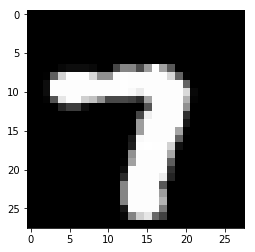

In [12]:
%matplotlib inline
# First row is first image
idx = len(train_data.data)
image = train_data.data[np.random.randint(0, idx)]

# h_train = h5py.File(test_data_file)
# image = np.array(h_train.get('ABNORMAL'))[156]

# 784 columns correspond to 28x28 image
plottable_image = np.reshape(image, (28, 28))

# Plot the image
plt.imshow(plottable_image, cmap='gray')
plt.show()

## Define Model

DEBUG:root:Starting session
DEBUG:root:Start training loop...
INFO:root:Initialising Model
INFO:root:Training iteration 0 of 1000


iter 0	train disc cost	4.338003158569336	time	1.5141322612762451
iter 1	train disc cost	4.131653785705566	time	0.5235514640808105
iter 2	train disc cost	4.1008734703063965	time	0.3976120948791504
iter 3	train disc cost	3.9557673931121826	time	0.3988943099975586
iter 4	train disc cost	3.786590337753296	time	0.39756107330322266


INFO:root:Saving fake samples to png: [[4.5318106e-01 3.3724642e-01 3.2442299e-01 ... 1.4910053e-03
  3.6735837e-03 3.7165214e-03]
 [4.5410407e-01 2.8775501e-01 2.8686199e-01 ... 9.7654434e-04
  1.6865514e-03 1.2536920e-03]
 [4.5773354e-01 3.0654213e-01 3.0987838e-01 ... 1.9302388e-03
  2.0737920e-03 1.3215772e-03]
 ...
 [4.4617227e-01 2.8591776e-01 2.9912177e-01 ... 1.4012185e-04
  1.2098489e-03 1.9237678e-03]
 [4.4343299e-01 3.0199662e-01 3.0264845e-01 ... 1.2053531e-03
  2.9706766e-03 4.5021758e-03]
 [4.5633763e-01 3.3262840e-01 3.3583495e-01 ... 1.2789377e-03
  4.0228679e-03 3.3189750e-03]]
INFO:root:Training iteration 100 of 1000


iter 99	train disc cost	0.6752796173095703	time	0.3995419050517835


INFO:root:Saving fake samples to png: [[2.80908465e-01 8.64874572e-02 8.53459761e-02 ... 6.31776869e-01
  4.66572201e-05 3.90483270e-04]
 [2.43104622e-01 4.64854240e-02 4.99122478e-02 ... 8.84457707e-01
  1.41361443e-05 1.07476466e-04]
 [2.79325694e-01 7.09328726e-02 7.24943653e-02 ... 8.21312249e-01
  2.12769082e-05 1.25486171e-04]
 ...
 [2.45108247e-01 4.46113013e-02 5.25535829e-02 ... 4.17793661e-01
  7.23814946e-06 1.48032996e-04]
 [2.56303966e-01 6.33097515e-02 6.61846995e-02 ... 7.82230079e-01
  4.24271566e-05 6.00054045e-04]
 [2.91473836e-01 9.13340524e-02 9.71784443e-02 ... 7.76290596e-01
  6.57361379e-05 4.56316338e-04]]
INFO:root:Training iteration 200 of 1000


iter 199	train disc cost	-0.06765734404325485	time	0.39144062757492065


INFO:root:Saving fake samples to png: [[1.63294032e-01 2.98763122e-02 2.68526990e-02 ... 8.70364332e-08
  5.28289274e-06 1.00403224e-04]
 [1.19886361e-01 1.15313614e-02 1.08293639e-02 ... 3.23546665e-08
  1.32038087e-06 2.86639170e-05]
 [1.69937626e-01 2.63483599e-02 2.42110398e-02 ... 3.75266964e-08
  1.85018519e-06 2.64062983e-05]
 ...
 [1.29326403e-01 1.31835090e-02 1.42202321e-02 ... 2.68184963e-09
  6.14287558e-07 2.95954815e-05]
 [1.46129578e-01 2.10869573e-02 2.03526840e-02 ... 1.49866750e-07
  5.29977706e-06 1.76016925e-04]
 [1.80398598e-01 3.50114144e-02 3.44886705e-02 ... 2.05196855e-07
  8.57258146e-06 1.34591624e-04]]
INFO:root:Training iteration 300 of 1000


iter 299	train disc cost	-0.4922371804714203	time	0.39470810890197755


INFO:root:Saving fake samples to png: [[1.17980964e-01 1.81212928e-02 1.81228593e-02 ... 8.88702630e-07
  2.32089883e-06 2.26931472e-04]
 [7.85703883e-02 6.12990884e-03 6.92651141e-03 ... 3.39371013e-07
  5.12308304e-07 6.84619008e-05]
 [1.18947126e-01 1.47026675e-02 1.51088713e-02 ... 5.71045007e-07
  1.03370894e-06 7.69180187e-05]
 ...
 [8.65670964e-02 7.06920540e-03 8.71572550e-03 ... 4.80977249e-08
  2.51122003e-07 8.64645990e-05]
 [9.95549038e-02 1.12348953e-02 1.23670883e-02 ... 1.29034675e-06
  2.37253880e-06 3.78636993e-04]
 [1.29672825e-01 2.04016007e-02 2.20943615e-02 ... 1.23728182e-06
  3.14990325e-06 2.37675384e-04]]
INFO:root:Training iteration 400 of 1000


iter 399	train disc cost	-0.5464621186256409	time	0.3964222049713135


INFO:root:Saving fake samples to png: [[8.31729621e-02 1.03439270e-02 1.08091813e-02 ... 5.92981849e-07
  1.05742163e-06 3.28566384e-04]
 [5.50604872e-02 3.58838984e-03 4.31169616e-03 ... 2.34465574e-07
  2.17779473e-07 1.07014232e-04]
 [8.25056359e-02 8.31002742e-03 8.95287376e-03 ... 4.92768550e-07
  4.65639800e-07 1.21276302e-04]
 ...
 [5.44263162e-02 3.50458920e-03 4.52644657e-03 ... 3.80985412e-08
  1.02106249e-07 1.03316575e-04]
 [6.84654415e-02 6.18659286e-03 7.22199352e-03 ... 4.61156873e-07
  6.95675453e-07 3.84411920e-04]
 [9.43658352e-02 1.19513534e-02 1.35828853e-02 ... 8.09605297e-07
  1.36443430e-06 3.23990127e-04]]
INFO:root:Training iteration 500 of 1000


iter 499	train disc cost	-0.5778465270996094	time	0.39074045419692993


INFO:root:Saving fake samples to png: [[5.8381442e-02 6.2490865e-03 6.5325247e-03 ... 1.7801664e-06
  5.4918587e-07 2.9330238e-04]
 [3.5098568e-02 1.8710926e-03 2.2661856e-03 ... 7.3759566e-07
  1.0031523e-07 9.2477640e-05]
 [5.9459724e-02 5.1380121e-03 5.5487826e-03 ... 1.5138772e-06
  2.4644578e-07 1.1343248e-04]
 ...
 [3.7316769e-02 2.0627624e-03 2.6553732e-03 ... 1.2212746e-07
  4.3575842e-08 8.7235727e-05]
 [4.7642794e-02 3.5840757e-03 4.2151297e-03 ... 1.1235109e-06
  3.5317854e-07 3.2076123e-04]
 [6.7658678e-02 7.1916734e-03 8.1892228e-03 ... 2.7622655e-06
  9.6790473e-07 3.3621414e-04]]
INFO:root:Training iteration 600 of 1000


iter 599	train disc cost	-0.605074405670166	time	0.396772575378418


INFO:root:Saving fake samples to png: [[3.7464250e-02 3.6312600e-03 3.8077633e-03 ... 3.1573770e-06
  2.0318684e-07 1.5181472e-04]
 [1.9781545e-02 8.7419903e-04 1.0569647e-03 ... 1.5062260e-06
  3.0905319e-08 4.4171749e-05]
 [3.8229972e-02 2.9746438e-03 3.1829902e-03 ... 5.3382932e-06
  1.2540455e-07 7.5754717e-05]
 ...
 [2.3825726e-02 1.1782971e-03 1.5546504e-03 ... 4.4444840e-07
  2.1128123e-08 5.0495895e-05]
 [2.9703552e-02 1.9994532e-03 2.3717482e-03 ... 2.3871935e-06
  1.4000032e-07 1.7914784e-04]
 [4.2656343e-02 4.0274025e-03 4.6152794e-03 ... 4.5125857e-06
  3.3278286e-07 1.7533834e-04]]
INFO:root:Training iteration 700 of 1000


iter 699	train disc cost	-0.6030325889587402	time	0.3942518401145935


INFO:root:Saving fake samples to png: [[2.68546026e-02 2.53926730e-03 2.54410412e-03 ... 3.31086994e-05
  1.03779087e-07 2.26389675e-04]
 [1.42518375e-02 6.23901899e-04 7.32172921e-04 ... 2.81306802e-05
  1.65998575e-08 7.89939659e-05]
 [3.27327624e-02 2.73196446e-03 2.84773274e-03 ... 6.13744342e-05
  7.16401161e-08 1.19133489e-04]
 ...
 [1.76014621e-02 8.88777780e-04 1.08698360e-03 ... 9.05022443e-06
  1.44746757e-08 1.21443176e-04]
 [2.08524633e-02 1.42591423e-03 1.62139710e-03 ... 4.04486600e-05
  1.04200161e-07 3.23737884e-04]
 [3.10403630e-02 2.88009620e-03 3.16762738e-03 ... 6.43497260e-05
  1.85717909e-07 2.73393292e-04]]
INFO:root:Training iteration 800 of 1000


iter 799	train disc cost	-0.6215808987617493	time	0.39199343919754026


INFO:root:Saving fake samples to png: [[2.6174664e-02 2.3358082e-03 2.6116276e-03 ... 1.5038346e-04
  1.5534265e-07 2.4766085e-04]
 [1.3221577e-02 5.4243853e-04 6.7790580e-04 ... 1.1142239e-04
  2.4243018e-08 8.2644561e-05]
 [3.1161167e-02 2.4271989e-03 2.6869285e-03 ... 2.0921597e-04
  8.3460925e-08 1.0640156e-04]
 ...
 [1.5534829e-02 7.0845202e-04 9.2843617e-04 ... 4.3910812e-05
  2.0357625e-08 1.1945235e-04]
 [1.9690836e-02 1.2201511e-03 1.4892323e-03 ... 2.2700180e-04
  1.7924202e-07 3.9242153e-04]
 [2.5861613e-02 2.0514522e-03 2.4646642e-03 ... 2.4565696e-04
  3.0260489e-07 3.0903643e-04]]
INFO:root:Training iteration 900 of 1000


iter 899	train disc cost	-0.6187341213226318	time	0.39831033706665037


INFO:root:Saving fake samples to png: [[1.9792074e-02 1.4253516e-03 1.7407134e-03 ... 1.5812565e-06
  7.4303216e-08 4.1383242e-05]
 [9.3807830e-03 2.9812526e-04 4.2994044e-04 ... 5.0807864e-07
  1.3394855e-08 1.1225887e-05]
 [2.5547370e-02 1.6905915e-03 2.0774752e-03 ... 1.3998433e-06
  4.0463892e-08 1.5851027e-05]
 ...
 [1.3941198e-02 5.6619698e-04 8.3418004e-04 ... 1.6263664e-07
  8.0373699e-09 1.2934073e-05]
 [1.5097659e-02 7.6159392e-04 1.0576108e-03 ... 2.6726750e-06
  9.4376652e-08 6.3013526e-05]
 [2.0613508e-02 1.3708057e-03 1.8069732e-03 ... 1.6702446e-06
  1.1467562e-07 4.1035801e-05]]
DEBUG:root:Training complete.


iter 999	train disc cost	-0.6164615750312805	time	0.39267109155654906


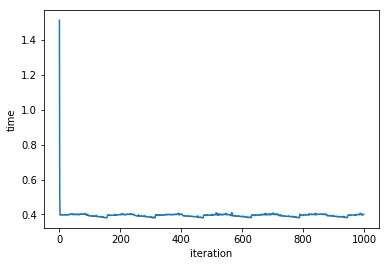

In [4]:
model_dir = './mnist_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

batch_size = 64
output_dimensions = 784
train_iters = 1000
plot_save_path = model_dir

model = RickAndMorty(batch_size=batch_size, 
                     output_dimensions=output_dimensions, 
                     train_iters=train_iters,
                     plot_save_path=plot_save_path)

detective = RickAndMortyDetective(model_configuration={
    'model': model,
    'batch_size': batch_size,
    'output_dimensions': output_dimensions,
    'train_iters': train_iters,
    'save_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
    'plot_save_path' : plot_save_path
})

detective.train(train_data)

## Evaluate Results

### Load trained model

In [5]:
# detective = RickAndMortyDetective(model_configuration={
#     'batch_size': 64,
#     'output_dimensions': 784,
#     'train_iters': 300,
#     'load_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
#     'plot_save_path' : model_dir
# })

### Load test data


In [6]:
# Get test data
test_data_normal = test_data_source.get_train_data('NORMAL')
test_data_abnormal = test_data_source.get_train_data('ABNORMAL')
test_data = test_data_source.get_train_data('ALL')

# Ground truth for ABNORMAL data is 1 , ground truth for NORMAL data is 0
n1 = np.ones(len(test_data_abnormal.data))
n2 = np.zeros(len(test_data_normal.data))
expected_truth = np.hstack((n1, n2))

### Calculate ROC Score

In [7]:
detection_result = detective.detect(test_data)

roc_score = GANPerformanceAnalysis({}).analyse(
  detection_result=detection_result.data,
  expected_truth=expected_truth
)

print('ROC Score: {}'.format(roc_score))

INFO:root:Running detector on <alphai_watson.datasource.Sample object at 0x7f9dcc8130f0>
INFO:root:Detection completed in 1.0748032629489899


ROC Score: 0.5523951865601436


### Generate classification report

In [8]:
# Save ; Compared ground truth to np.rint(detection_result.data), which rounds probability <0.5 to 0 and >0.5 to 1
clf_rep = precision_recall_fscore_support(expected_truth, np.rint(detection_result.data))
out_dict = {
             "precision" :clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
df_out = pd.DataFrame(out_dict, index = ['NORMAL', 'ABNORMAL'])
avg_tot = (df_out.apply(lambda x: round(x.mean(), 2) if x.name != "support" else  round(x.sum(), 2)).to_frame().T)
avg_tot.index = ["avg/total"]
df_out = df_out.append(avg_tot)
print(df_out)

# Save Classification report to CSV (Optional)
# df_out.to_csv('classification_report_digit-{}.csv'.format(abnormal_digit), sep=';')

           f1-score  precision  recall  support
NORMAL         0.00       0.00     0.0  12636.0
ABNORMAL       0.52       0.35     1.0   6824.0
avg/total      0.26       0.18     0.5  19460.0


/opt/anaconda/envs/ai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
